# Integration geospatial raster-vector data in VKG system Ontop

## 0. Imports

In [269]:
import sys
import os
import numpy as np
import pandas as pd
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import geopandas as gpd
# import shapefile as sh
# import fiona
import shapely
from shapely.geometry import LineString, MultiPolygon, Polygon, box, MultiPoint, Point, LinearRing
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# from wktplot import WKTPlot
# from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.__version__}")
print(f"Shapely GEOS version {shapely.geos_version_string}")
print(f"Shapely GEOS C API version {shapely.geos_capi_version_string}")

Py version 3.8.10
Shapely version 2.0.1
Shapely GEOS version 3.11.1
Shapely GEOS C API version 3.11.1-CAPI-1.17.1


## 1. Functions

In [148]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

def grid2WKT_ring(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    ring = LinearRing(zip(long_array, lat_array))
    return ring

# def grid2WKT_polygon_02(long_array, lat_array):
#     """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(x_grid, y_grid))
#     polygon = "POLYGON((" + ", ".join(f"{y} {x}" for x, y in coordinates) + "))"
#     return polygon

# def wktDisplay(polygon):
#     # Create plot object just like standard WKTPlot class
#     plot = OpenStreetMapsPlot("Open Street Map Plot", 
#                               height=600,
#                               width=600,
#                               disable_mercator=False)
#     plot.add_shape(polygon, fill_alpha=0.5, fill_color="firebrick")
#     plot.show()
    
# def GetExtent(ds):
#     """ Return list of corner coordinates from a gdal Dataset """
#     xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
#     width, height = ds.RasterXSize, ds.RasterYSize
#     xmax = xmin + width * xpixel
#     ymin = ymax + height * ypixel
#     extent_dict = {
#       'lons_width': width, 
#       'lats_height': height, 
#       'xpixel': xpixel, 
#       'ypixel': ypixel,
#       'Upper_Left':[xmin, ymax],
#       'Bottom_Left':[xmin, ymin],
#       'Upper_Right':[xmax, ymax],
#       'Bottom_Right':[xmax, ymin]        
#     }
#     return extent_dict
#     #return (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin), (xpixel, ypixel), (width, height)

  
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)

    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

# def add_closing_coordinates_holes(d):
#     """ Adds the first 'lat long' to the end for polygons with one hole"""
#     # Find the start of the first set of coordinates in the exterior ring
#     i_exterior = re.search(r"\d", d).start()
    
#     # Find the end of the interior ring (hole)
#     j_interior = re.search(r'(\d)[^\d]*$', d).start() + 1
    
#     # Find the comma separating the lat and long in the exterior ring
#     c_exterior = d.index(',')

#     # Find the comma separating the lat and long in the interior ring
#     c_interior = d[j_interior:].index(',') + j_interior
    
#     # Concatenate the exterior ring and the first set of coordinates to close it
#     result = d[:c_exterior] + d[i_exterior:c_exterior] + d[c_exterior:]

#     # Concatenate the interior ring and the first set of coordinates to close it
#     result = result[:c_interior] + d[i_exterior:c_exterior] + result[c_interior:]

#     return result


# def geoPOLYGON_to_gridPOLYGON(polygon_str):
#     data = str(polygon_str)
#     data_wkt = add_closing_coordinates(data)
#     polygon = wkt.loads(data_wkt)
#     coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
#     expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
#     lat_arr = []
#     long_arr = []
#     for i in range(len(expected_list_of_coordinates_for_received_code)):
#         long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
#         lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])
    
#     long_list = long_arr.tolist()
#     lat_list = lat_arr.tolist()
    
#     return long_list, lat_list


def processRING(ring):
    lat_arr = []
    long_arr = []
    if ring.is_closed == True:
        # Extract longitudes and latitudes
        longitudes, latitudes = zip(ring.xy)
        
        for i in range(len(latitudes[0])):
            long_arr = np.append(long_arr, longitudes[0][i])
            lat_arr = np.append(lat_arr, latitudes[0][i])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridRING_yx = grid2WKT_ring(y_grid, x_grid)

        return gridRING_yx
    else:
        print("Incomplete ring")

def processPOLYGON(inputPOLYGON, regionID = None):
    if len(inputPOLYGON.interiors) == 0:
        polygon = wkt.loads(add_closing_coordinates(inputPOLYGON))
        coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
        expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
        lat_arr = []
        long_arr = []
        for i in range(len(expected_list_of_coordinates_for_received_code)):
            long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
            lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])

        long_list = long_arr.tolist()
        lat_list = lat_arr.tolist()

        x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
        gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)

        return gridPOLYGON_yx
    else:
        print(f"{regionID}: Polygon Ring Detected")
        mainPOLYGON = Polygon(inputPOLYGON.exterior)  # Convert main ring to main polygon without inner ring
        gridPOLYGON_yx = processPOLYGON(mainPOLYGON)
#         for i in range(0, len(inputPOLYGON.interiors)):
#             gridRING_yx = processRING(inputPOLYGON.interiors[i])
        
#         gridPOLYGON_yx_assembled = gridPOLYGON_yx.symmetric_difference(Polygon(gridRING_yx))
        
        return gridPOLYGON_yx #return gridPOLYGON_yx_assembled
         

           

######## Mother Function ##############################################################################################
########################################################################################

def geoPOLYGON_to_gridPOLYGON_03(inputREGION, regionID = None):
    polygons_array1 = []
    polygons_array2 = []
    i = 0
    r = 0
    if inputREGION.geom_type == 'Polygon':
        print(f"{regionID}: Polygon is processing")
        return processPOLYGON(inputREGION, regionID)
    
    elif len(list(inputREGION.geoms[0].interiors)) > 0:    # MultiPolygon with atleast 1 inner rings
        print(f"{regionID}: MultiPolygon has Inner Rings")        
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array1.append(gridPOLYGON)
            r = r +1
            
        gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array1]
        return shapely.geometry.MultiPolygon(gridMULTI)

    else:                                                  # MultiPolygon with 0 rings
        print(f"{regionID}: MultiPolygon is processing")
        for polygon in inputREGION.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array2.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array2]
        return shapely.geometry.MultiPolygon(gridMULTI)
          
        
def breakMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        return str("")
    else:
        for polygon in multipolygon.geoms:
            polygons_array.append(polygon)

#     print("# of internal polygons is ",len(polygons_array))
    return polygons_array

def repairMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        print("Flag 1")
        return str("")
    else:
        print("Flag 2")
        for polygon in multipolygon.geoms:
            polygon = wkt.loads(add_closing_coordinates(str(polygon)))
            polygons_array.append(polygon)
    print("Flag 3")
    return unary_union(polygons_array)

def checkMULTIPOLYGONS(df):
   """checks if a vector data has multipolygons"""
   df = df.assign(isMULTI=df['geometry'].apply(lambda row :len(breakMULTIPOLYGONS(wkt.loads(str(row))))))
   df_multipolygons = df[df['isMULTI'] > 0]
   view = pd.DataFrame({'Districts':df_multipolygons['NAME_2'],'MultiPolygons':df_multipolygons['isMULTI']})
   return view


######## RasDaMan F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis (Longitude)')
    plt.ylabel('y-axis (Latitude)')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2numeric(query):
    result = query_executor.execute_read(query) 
    return float("{}".format(result))

def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    return result


def visuallizeARRAY(data, title="Beautiful Image but please put a signifaciant title"):
    """accept an array and return shape and visualize the array in heat map"""
    data = np.array(data)
    if len(data.shape) > 1:
        ax = sns.heatmap(np.array(data) , cmap = 'Spectral_r') #inferno
    else:
        ax = sns.heatmap(data[:, np.newaxis], cmap='Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return np.array(data).shape

def checkRASTER(RASTER_NAME, FILL = 50.0):
    q_ansi_upper = 'select sdom(t)[0].hi from '+str(RASTER_NAME)+' as t'
    q_lat_upper = 'select sdom(y)[1].hi from '+str(RASTER_NAME)+' as y'
    q_long_upper = 'select sdom(x)[2].hi from '+str(RASTER_NAME)+' as x'
    
    gridTime = int("{}".format(query2result(q_ansi_upper)))+1;  # index start from 0 in rasdaman so +1
    gridLat = int("{}".format(query2result(q_lat_upper)))+1;
    gridLong = int("{}".format(query2result(q_long_upper)))+1;
#     q = "select sdom(c) from "+str(RASTER_NAME)+" as c"
#     MDD = "{}".format(query2result(q))
#     time = int(MDD.split(",")[0].split(":")[1])+1
#     gridLat = int(MDD.split(",")[1].split(":")[1])+1
#     gridLong = int(MDD.split(",")[2].split(":")[1].split("]")[0])+1
    
    Time = []
    TOTAL = []
    VALID = []
    RATIO = []
    print("Entering the time loop \n")
    for t in range(0, gridTime):
        q = 'select (raster['+str(t)+', 0:* , 0:*]*0.02)-273.15 from '+str(RASTER_NAME)+' as raster' 
        array = query2array(q)
        if np.count_nonzero(array)*100/array.size >= FILL:   # Threshold parcentage of valid pixels
            Time = np.append(Time, t)
            TOTAL = np.append(TOTAL, array.size)
            VALID = np.append(VALID, np.count_nonzero(array))
            RATIO = np.append(RATIO, np.count_nonzero(array)*100/array.size)
            print(f"Time = {t}, \t VALID = {np.count_nonzero(array)} / {array.size},\t\t Coverage(%) = {'{:.2f}'.format(np.count_nonzero(array)*100/array.size)}")
    
    
    fig = plt.figure(figsize = (16, 5))
    # creating the bar plot
    bar = plt.bar(Time, RATIO, color ='maroon', width = 1)
    # Add counts above the two bar graphs
    for rect in bar:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')

    plt.xlabel("Temporal Snaps")
    plt.ylabel("Valid / Total")
    plt.title(f"Raster Name: {RASTER_NAME}")
    plt.show()
    return MDD

## 2. Explainatory Data Analysis

### 2.1 Geometric Vector Data (relational data)

In [3]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Baveria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')

In [4]:
view = pd.DataFrame({'Districts':gdfBAV['NAME_2'],'geom':gdfBAV['geometry']})
view

Districts  \
0             Aichach-Friedberg   
1                     Altötting   
2                        Amberg   
3               Amberg-Sulzbach   
4                       Ansbach   
..                          ...   
91            Weilheim-Schongau   
92      Weißenburg-Gunzenhausen   
93  Wunsiedel im Fichtelgebirge   
94                     Würzburg   
95  Würzburg (Kreisfreie Stadt)   

                                                 geom  
0   POLYGON ((11.03899 48.22127, 11.04266 48.22036...  
1   POLYGON ((12.61187 48.06424, 12.60968 48.06479...  
2   POLYGON ((11.78115 49.42765, 11.78099 49.42811...  
3   POLYGON ((11.96819 49.61406, 11.96912 49.61361...  
4   POLYGON ((10.66370 49.08374, 10.66685 49.08319...  
..                                                ...  
91  POLYGON ((10.97286 47.69561, 10.97356 47.69552...  
92  POLYGON ((11.04477 48.90070, 11.04352 48.89983...  
93  POLYGON ((11.90024 49.98885, 11.89903 49.98987...  
94  POLYGON ((9.93395 49.48361, 9.92981 49.48433, ...  
95  POLYGON ((9.98563 49.73700, 9.98168 49.73645, ...  

[96 rows x 2 columns]

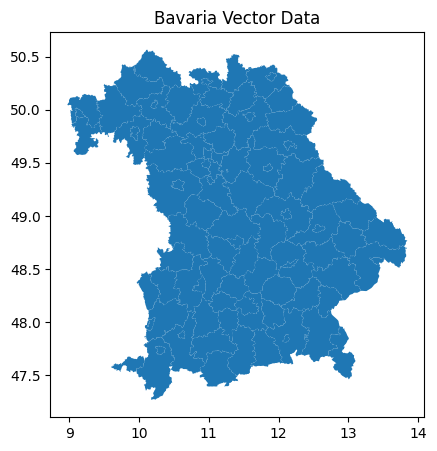

In [5]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfBAV.plot(ax=ax1)
# Add a title to your plot
ax1.set(title="Bavaria Vector Data")
plt.show()

In [6]:
# gdfBAV_multipolygons = gdfBAV[gdfBAV['isMULTI'] > 0]
# view = pd.DataFrame({'Districts':gdfBAV_multipolygons['NAME_2'],'MultiPolygons':gdfBAV_multipolygons['isMULTI']})
# view

In [7]:
checkMULTIPOLYGONS(gdfSWE)

Districts  MultiPolygons
0        Ödeshög              3
1     Åtvidaberg              2
2        Boxholm              2
8     Norrköping             88
9    Söderköping            133
..           ...            ...
275        Tanum            122
276        Tibro              2
278        Tjörn             54
281    Uddevalla             24
283   Vänersborg              4

[120 rows x 2 columns]

### 2.2 Raster Data (multi-dimensional arrays)

#### 2.1.1 Geotiff

#### 2.2.2 NetCDF

In [8]:
raster01_path = '/home/arkaghosh/Downloads/Baveria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'

In [9]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [10]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())

ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [11]:
xmin, xmax

(8.979166665862266, 13.837499998760364)

In [12]:
ymin, ymax

(47.270833329098565, 50.56249999547035)

#### 2.2.3 RasDaMan

In [214]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [14]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list

In [15]:
collection_list = list(collection_list)
collection_list

['LST_03_GeoTIFF_FLIPPED',
 'World_Air_Temperature',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'Surface_Temperature_Sweden',
 'Baveria_Temperature_MODIS_1km',
 'AIR_TEMP_X']

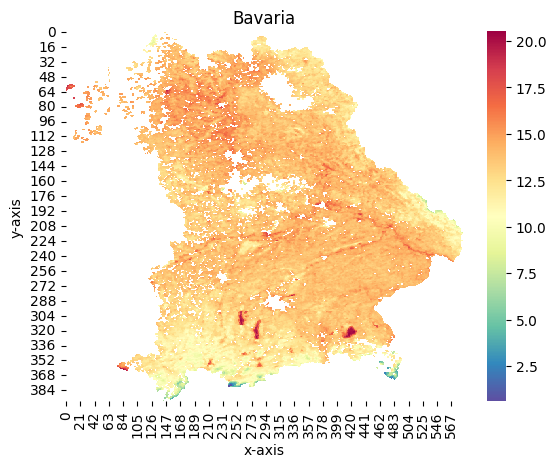

True

In [16]:
q = "select (mr[178, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria",0)

[0:303,0:395,0:583]
<class 'rasdapy.models.result_array.ResultArray'>
Entering the time loop 

Time = 38, 	 VALID = 125290 / 231264,		 Coverage(%) = 54.18
Time = 50, 	 VALID = 118563 / 231264,		 Coverage(%) = 51.27
Time = 122, 	 VALID = 122156 / 231264,		 Coverage(%) = 52.82
Time = 144, 	 VALID = 123820 / 231264,		 Coverage(%) = 53.54
Time = 146, 	 VALID = 125465 / 231264,		 Coverage(%) = 54.25
Time = 147, 	 VALID = 124505 / 231264,		 Coverage(%) = 53.84
Time = 153, 	 VALID = 122194 / 231264,		 Coverage(%) = 52.84
Time = 162, 	 VALID = 126310 / 231264,		 Coverage(%) = 54.62
Time = 187, 	 VALID = 124294 / 231264,		 Coverage(%) = 53.75
Time = 221, 	 VALID = 122824 / 231264,		 Coverage(%) = 53.11
Time = 229, 	 VALID = 124190 / 231264,		 Coverage(%) = 53.70
Time = 231, 	 VALID = 120204 / 231264,		 Coverage(%) = 51.98
Time = 232, 	 VALID = 121820 / 231264,		 Coverage(%) = 52.68
Time = 234, 	 VALID = 121946 / 231264,		 Coverage(%) = 52.73
Time = 246, 	 VALID = 125598 / 231264,		 Coverage(%) 

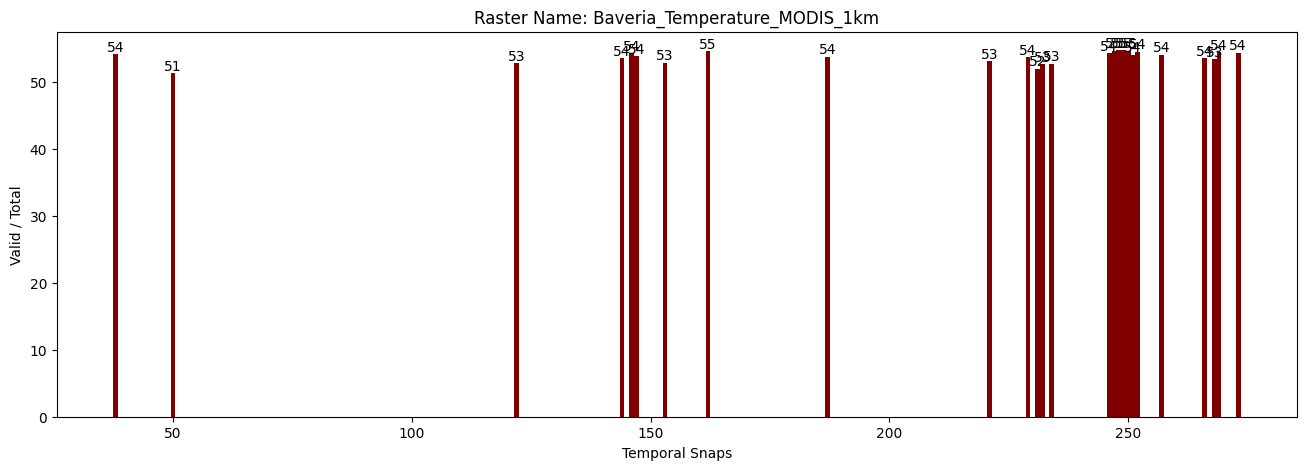

'[0:303,0:395,0:583]'

In [17]:
checkRASTER('Baveria_Temperature_MODIS_1km', 51)

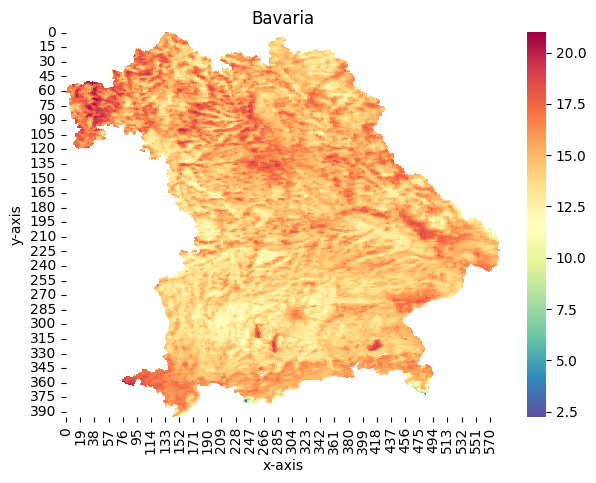

True

In [18]:
q = "select (mr[249, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria",0)

[0:216,0:1647,0:1585]
<class 'rasdapy.models.result_array.ResultArray'>
Entering the time loop 

Time = 18, 	 VALID = 1082413 / 2613728,		 Coverage(%) = 41.41
Time = 20, 	 VALID = 1123269 / 2613728,		 Coverage(%) = 42.98
Time = 101, 	 VALID = 1074043 / 2613728,		 Coverage(%) = 41.09
Time = 145, 	 VALID = 1133569 / 2613728,		 Coverage(%) = 43.37


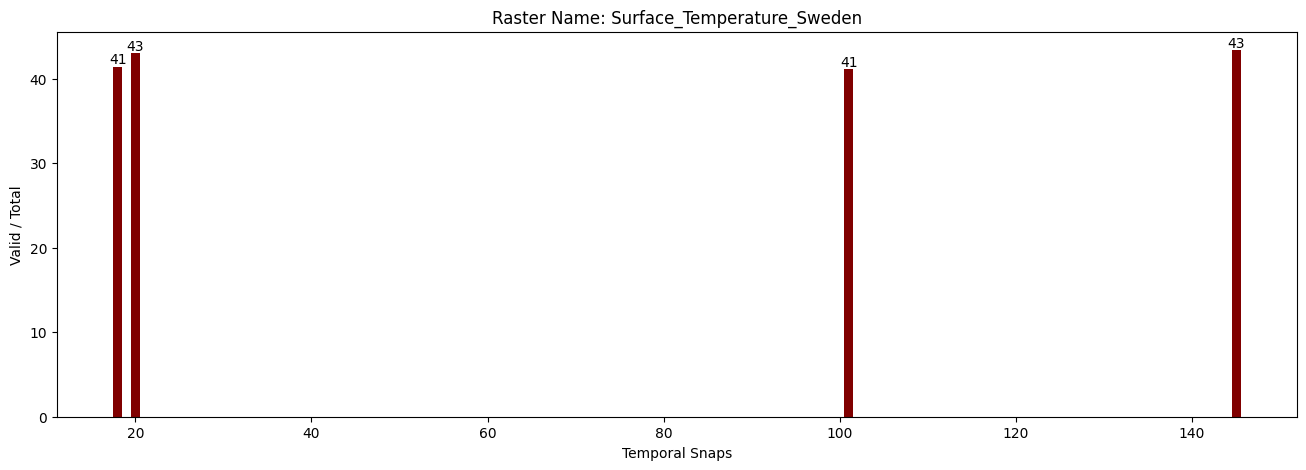

'[0:216,0:1647,0:1585]'

In [19]:
checkRASTER('Surface_Temperature_Sweden', 40)

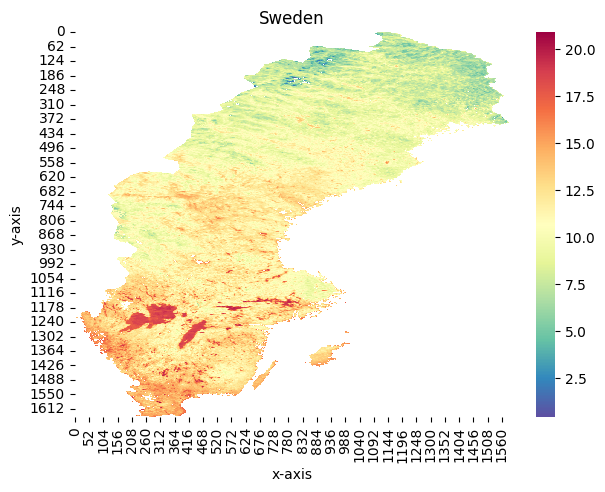

True

In [20]:
q = "select (mr[145, 0:* , 0:*]*0.02)-273.15 from Surface_Temperature_Sweden as mr" #100, 178
query2array2visuallize(q, "Sweden",0)

## 3. Resolving Issues

### ISSUE #01: Automate Metadata Retrival for each raster

#### Necessary Metadata for raster data

In [31]:
xmin, xmax

(8.979166665862266, 13.837499998760364)

In [32]:
ymin, ymax

(47.270833329098565, 50.56249999547035)

In [33]:
pixel_size = 0.00833333333258679

### ISSUE #02: Resolving Multipolygons in Vector Data

Some tips:

 1. https://blogs.sap.com/2016/08/30/importing-shapefiles-in-sap-hana-and-the-validity-of-geometries/

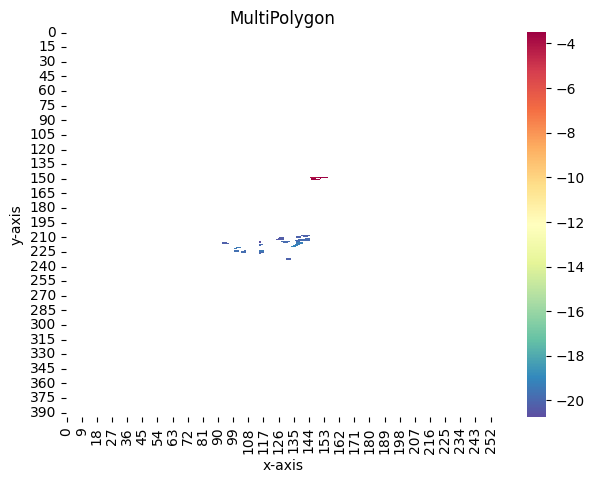

True

In [21]:
qUmea = "select clip((m[20, 0:* , 0:*]*0.02) - 273.15, MULTIPOLYGON(((100 200, 352 400, 384 441, 100 200)), ((1 457, 352 400, 384 441, 1 457)),((400 315, 150 315, 150 360,400 315 )))) from Baveria_Temperature_MODIS_1km as m" 
query2array2visuallize(qUmea, "MultiPolygon", 0)

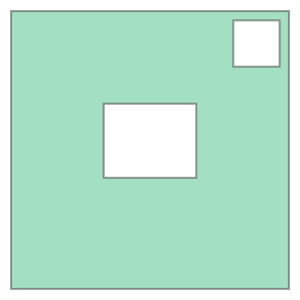

In [22]:
polygon = Polygon(

    shell=[(0, 0), (0, 300), (300, 300), (300, 0), (0, 0)],

    holes=[[(100, 120), (200, 120), (200, 200), (100, 200), (100, 120)],[(240, 240), (240, 290), (290, 290), (290, 240), (240, 240)]],

)

polygon

In [23]:
len(list(polygon.interiors))

2

In [24]:
list(polygon.exterior.coords)

[(0.0, 0.0), (0.0, 300.0), (300.0, 300.0), (300.0, 0.0), (0.0, 0.0)]

In [25]:
print(polygon)

POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))


In [26]:
x = wkt.loads(0 0, 0 300, 300 300, 300 0, 0 0)

SyntaxError: invalid syntax (1262204753.py, line 1)

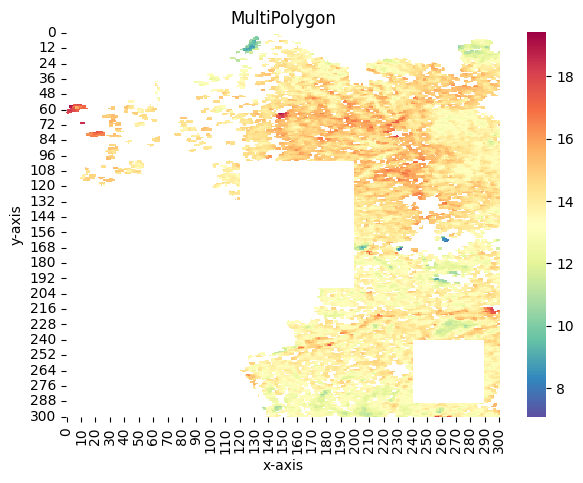

True

In [27]:
qUmea = "select clip((m[178, 0:* , 0:*]*0.02) - 273.15, POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))) from Baveria_Temperature_MODIS_1km as m" 
query2array2visuallize(qUmea, "MultiPolygon", 0)

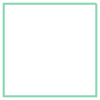

In [28]:
ring = LinearRing( ((2, 2), (2, 1), (1 ,1 ), (1 , 2)) )
ring

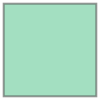

In [29]:
polygon = Polygon([(0, 0), (0, 5), (5, 5), (5, 0), (0, 0) ])
polygon

In [30]:
unary_union(polygon, ring)

TypeError: unary_union() takes 2 positional arguments but 3 were given

In [34]:
checkMULTIPOLYGONS(gdfBAV)

Districts  MultiPolygons
12                      Bamberg              2
15  Bayreuth (Kreisfreie Stadt)              2
16         Berchtesgadener Land              2
17                         Cham              8
59   München (Kreisfreie Stadt)              2
65                     Nürnberg              2
67                   Oberallgäu              2
68                    Ostallgäu              2
75                Rhön-Grabfeld              2
76                    Rosenheim              4
82                  Schweinfurt              3
87                Tirschenreuth              2
89                  Unterallgäu              2

### Rosenheim

Rosenheim


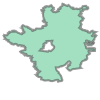

In [35]:
gid = 76 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [36]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.2 47.64, 12.201 47.638, 12.201 47.637, 12.202 47.636, 12.202 4...>,
 <POLYGON ((12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47...>,
 <POLYGON ((12.415 47.868, 12.415 47.868, 12.415 47.869, 12.416 47.869, 12.41...>,
 <POLYGON ((12.425 47.876, 12.426 47.876, 12.426 47.876, 12.426 47.876, 12.42...>]

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


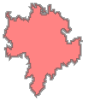

In [37]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

In [38]:
x = geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
print(x)

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected
MULTIPOLYGON (((350 386, 350 386, 351 386, 351 386, 351 386, 351 386, 351 386, 351 386, 352 386, 352 386, 352 386, 352 386, 352 387, 352 387, 352 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 353 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 387, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 386, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 385, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 355 384, 355 384, 355 384, 355 384, 355 384, 355 384, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 383, 355 384, 355 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 354 384, 353 384, 353 384, 353 384, 353 384, 353 3

In [39]:
print(list(INPUT.geoms)[0].interiors[0])

LINEARRING (12.082866669000111 47.86521911700015, 12.078197480000028 47.864585877000195, 12.076551438000081 47.86043167200012, 12.077123642000004 47.858428956000125, 12.077441215000079 47.857334137000066, 12.077728271000012 47.85634994600008, 12.078222274000154 47.85522460900012, 12.080194474000052 47.85500717100007, 12.079779625000128 47.85417938200004, 12.081133843000089 47.85406875700005, 12.08086776800019 47.8531150820001, 12.080597878000049 47.852146149000134, 12.078303338000126 47.85220336900005, 12.078035355000054 47.851623535000044, 12.077282905000118 47.85015869100016, 12.078485489000172 47.85018921000011, 12.079718589000038 47.85007476700014, 12.082356453000159 47.84970474200003, 12.081993103000116 47.84877777100013, 12.081013680000183 47.84748840300006, 12.08044624300004 47.84706878600002, 12.079396249000013 47.846633911000026, 12.078698159000169 47.845958709000115, 12.078384399000129 47.84449005100009, 12.078827858000182 47.84281158400006, 12.07838249200006 47.8402976990001

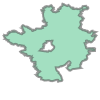

In [40]:
mulPOLY[0]

In [41]:
print(mulPOLY[0])

POLYGON ((12.200161721000029 47.64013822700002, 12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.208

In [42]:
len(list(mulPOLY[0].exterior.coords))

3648

In [43]:
len(list(mulPOLY[0].interiors))

1

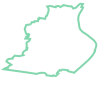

In [44]:
list(mulPOLY[0].interiors)[0]

In [45]:
list(mulPOLY[0].interiors)[0].geom_type

'LinearRing'

In [46]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

1
0
0
0


In [47]:
len(breakMULTIPOLYGONS(INPUT)[0].interiors)

1

In [48]:
len(breakMULTIPOLYGONS(INPUT)[3].interiors)

0

In [49]:
list(breakMULTIPOLYGONS(INPUT)[0].interiors)[0].geom_type

'LinearRing'

In [50]:
len((INPUT.geoms))

4

In [51]:
# INPUT string
input_string = "POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))"

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\(([^())]+)\)')

# pattern = re.compile(r'\([^)]+\)')
# pattern = re.compile(r'\([^)]+\)')
# Use findall to extract all matches
polygons = pattern.findall(input_string)

# Print individual polygons
for i, polygon in enumerate(polygons, start=1):
    print(f"({polygon})")
    print("-------------------------------------------------------------")

# Assemble the polygons again
assembled_string = "POLYGON (" + ", ".join(f"({polygon})" for polygon in polygons) + ")"
print("\nAssembled String:")
print(assembled_string)

(0 0, 0 300, 300 300, 300 0, 0 0)
-------------------------------------------------------------
(100 120, 200 120, 200 200, 100 200, 100 120)
-------------------------------------------------------------
(240 240, 240 290, 290 290, 290 240, 240 240)
-------------------------------------------------------------

Assembled String:
POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))


In [52]:
polygons

['0 0, 0 300, 300 300, 300 0, 0 0',
 '100 120, 200 120, 200 200, 100 200, 100 120',
 '240 240, 240 290, 290 290, 290 240, 240 240']

In [53]:
# INPUT string
input_string = str(mulPOLY[0])

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\(([^)]+)\)')

# Use findall to extract all matches
polygons = pattern.findall(input_string)

# Print individual polygons
for i, polygon in enumerate(polygons, start=1):
    print(f"({polygon})")
    print("--------------------------------------------------------------------------------------------------")

# # Assemble the polygons again
# assembled_string = "POLYGON " + ", ".join(f"({polygon})" for polygon in polygons) + ")"
# print("\nAssembled String:")
# print(assembled_string)

((12.200161721000029 47.64013822700002, 12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.20849688300

In [54]:
# INPUT string
input_string = "POLYGON ( (0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))"

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\([^)]+\)')

# Use findall to extract all matches
polygons = pattern.findall(input_string)

In [55]:
polygons

['( (0 0, 0 300, 300 300, 300 0, 0 0)',
 '(100 120, 200 120, 200 200, 100 200, 100 120)',
 '(240 240, 240 290, 290 290, 290 240, 240 240)']

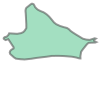

In [56]:
mulPOLY[1]

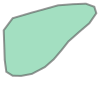

In [57]:
mulPOLY[2]

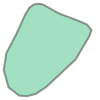

In [58]:
mulPOLY[3]

76: MultiPolygon has Inner Rings
None: Polygon Ring Detected


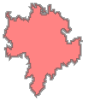

In [59]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

In [60]:
INPUT.geom_type

'MultiPolygon'

### Cham

Cham


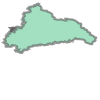

In [61]:
gid = 17 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [62]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.495 49.061, 12.494 49.061, 12.493 49.06, 12.493 49.06, 12.493 ...>,
 <POLYGON ((12.372 49.237, 12.372 49.237, 12.374 49.238, 12.374 49.238, 12.37...>,
 <POLYGON ((12.379 49.241, 12.381 49.241, 12.385 49.241, 12.385 49.24, 12.381...>,
 <POLYGON ((12.371 49.243, 12.373 49.245, 12.373 49.245, 12.376 49.245, 12.37...>,
 <POLYGON ((12.395 49.25, 12.395 49.25, 12.392 49.251, 12.392 49.251, 12.39 4...>,
 <POLYGON ((12.368 49.26, 12.37 49.259, 12.37 49.259, 12.372 49.26, 12.373 49...>,
 <POLYGON ((12.385 49.267, 12.385 49.267, 12.387 49.267, 12.387 49.267, 12.38...>,
 <POLYGON ((12.408 49.264, 12.408 49.264, 12.407 49.264, 12.405 49.264, 12.40...>]

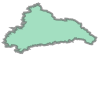

In [63]:
mulPOLY[0]

In [64]:
len(list(mulPOLY[0].exterior.coords))

2585

In [65]:
len(list(mulPOLY[0].interior))

AttributeError: 'Polygon' object has no attribute 'interior'

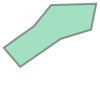

In [67]:
mulPOLY[1]

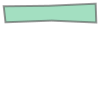

In [68]:
mulPOLY[2]

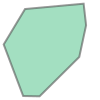

In [69]:
mulPOLY[3]

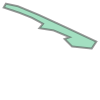

In [70]:
mulPOLY[4]

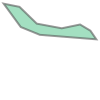

In [71]:
mulPOLY[5]

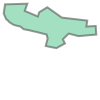

In [72]:
mulPOLY[6]

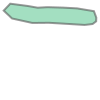

In [73]:
mulPOLY[7]

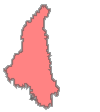

In [74]:
x = geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
x

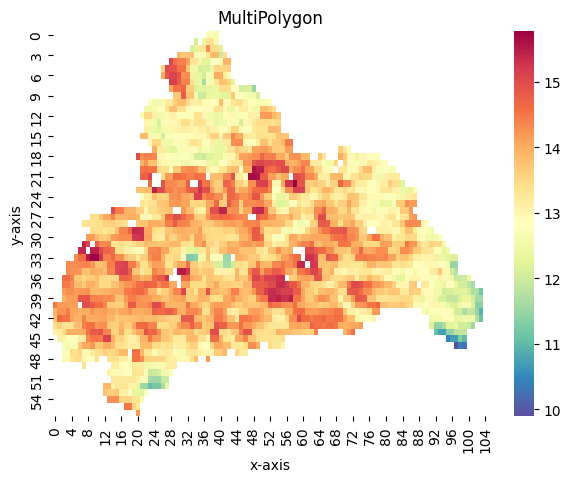

True

In [75]:
qCham = 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qCham, "MultiPolygon", 0)

In [76]:
poly_1 = Polygon([(20,20), (60,20), (60,40), (20,40)])
poly_2 = Polygon([(60,50), (60,70), (80,70), (80,50)])
 
polygons = unary_union([poly_1, poly_2])
print(polygons)

MULTIPOLYGON (((20 40, 60 40, 60 20, 20 20, 20 40)), ((60 70, 80 70, 80 50, 60 50, 60 70)))


In [77]:
type(poly_1)

shapely.geometry.polygon.Polygon

In [78]:
print(repairMULTIPOLYGONS(polygons))

Flag 2
Flag 3
MULTIPOLYGON (((60 40, 60 20, 20 20, 20 40, 60 40)), ((80 70, 80 50, 60 50, 60 70, 80 70)))


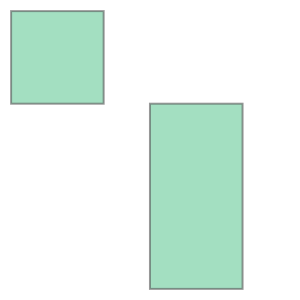

In [81]:
poly = geoPOLYGON_to_gridPOLYGON_03(polygons)
poly

In [82]:
type(poly[1])

TypeError: 'MultiPolygon' object is not subscriptable

Würzburg


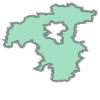

In [83]:
gid = 94 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [84]:
INPUT.geom_type

'Polygon'

In [85]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

AttributeError: 'Polygon' object has no attribute 'geoms'

In [86]:
print(INPUT.interiors[0].geom_type)

LinearRing


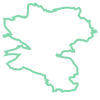

In [87]:
INPUT.interiors[0]

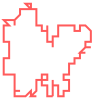

In [88]:
processRING(INPUT.interiors[0])

In [89]:
print(INPUT.interiors[0])

LINEARRING (9.875177989000008 49.76660228500003, 9.876224812000032 49.76682950200012, 9.876563073000057 49.76690292300003, 9.876662470000042 49.766934938000134, 9.87707981400007 49.767069362000086, 9.878453696000065 49.767511613000124, 9.882317001000104 49.76774200000011, 9.886770000000183 49.76813500000014, 9.889248999000074 49.76765400000011, 9.889681000000166 49.76757399900015, 9.89158700000013 49.767269000000056, 9.892061792000163 49.76725737400017, 9.892744906000189 49.76724044200017, 9.893588066000177 49.767219543000124, 9.896266937000007 49.767375946000186, 9.895339013000182 49.76607513400006, 9.893617630000108 49.764915467000094, 9.892480850000027 49.76366806100009, 9.892311022000172 49.76342002900003, 9.89191022100016 49.76283466200016, 9.891430855000124 49.762134552000134, 9.889101028000141 49.75968170200002, 9.885965347000138 49.75838851900005, 9.884824753000089 49.757438660000105, 9.883112898000093 49.7567807690001, 9.882645480000178 49.75660113500015, 9.882392884000069 49.

In [90]:
print(processRING(INPUT.interiors[0]))

LINEARRING (95 107, 95 107, 95 107, 95 107, 95 107, 95 107, 95 108, 95 108, 95 109, 95 109, 95 109, 95 109, 95 109, 95 109, 95 110, 95 109, 95 109, 95 109, 95 109, 95 109, 96 109, 96 109, 96 108, 96 108, 96 108, 96 108, 96 108, 96 108, 96 108, 96 107, 97 107, 97 108, 97 108, 97 108, 97 108, 98 108, 98 108, 98 109, 98 109, 98 109, 98 109, 98 109, 98 109, 98 110, 98 110, 97 110, 97 110, 97 110, 97 110, 97 110, 97 111, 98 111, 98 112, 98 112, 98 113, 98 113, 98 113, 99 113, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 99 114, 100 114, 100 114, 100 115, 100 115, 100 115, 100 115, 100 115, 100 114, 100 115, 100 115, 100 115, 100 115, 100 114, 100 114, 100 115, 100 115, 101 115, 101 115, 100 115, 100 115, 101 116, 101 116, 101 116, 101 116, 102 116, 102 116, 102 116, 102 116, 101 116, 101 116, 101 116, 101 117, 101 117, 101 117, 101 117, 102 117, 102 117, 102 117, 102 117, 102 118, 102 118, 102 118, 102 119, 102 119, 102 119, 101 120, 101 120, 101 120, 101 

In [91]:
from shapely.geometry import LinearRing

# Given Linear Ring
linear_ring_coords = processRING(INPUT.interiors[0])

# Create Shapely Linear Ring
linear_ring = LinearRing(linear_ring_coords)

# Extract longitudes and latitudes
longitudes, latitudes = zip(linear_ring_coords.xy)
latitudes[0][0]
longitudes[0][0]

95.0

In [92]:
len(longitudes[0])

384

In [93]:
len(latitudes[0])

384

In [94]:
latitudes[0][2]

107.0

In [95]:
lat_arr = []
long_arr = []
for i in range(len(latitudes[0])):
    long_arr = np.append(long_arr, longitudes[0][i])
    lat_arr = np.append(lat_arr, latitudes[0][i])
    
long_list = long_arr.tolist()
lat_list = lat_arr.tolist()

In [96]:
long_list

[95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 95.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 96.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 97.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 98.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 101.0,
 101.0,
 100.0,
 100.0,
 101.0,
 101.0,
 101.0,
 101.0,
 102.0,
 102.0,
 102.0,
 102.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 102.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 101.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99.0,
 99

In [97]:
INPUT.interiors[0].is_closed

True

In [98]:
list(breakMULTIPOLYGONS(INPUT)[0].interiors)[0].geom_type

IndexError: string index out of range

In [99]:
INPUT_str = str(INPUT)
INPUT_str.geom_type

AttributeError: 'str' object has no attribute 'geom_type'

In [100]:
INPUT_str = wkt.loads(INPUT_str)
INPUT_str.geom_type

'Polygon'

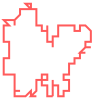

In [101]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

In [17]:
countEX = 0
countHALF = 0
vectorDB = gdfBAV
for gid in range(0,len(vectorDB)):
    INPUT = vectorDB.geometry[gid]
    try:
        geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
        print(f"{gid}:{vectorDB.NAME_2[gid]}")
    except:
        print(f"{gid}: {vectorDB.NAME_2[gid]}***")
        countEX+=1

print("\nNumber of Ring Case",countHALF)        
print("\nNumber of exceptions",countEX)

0: Aichach-Friedberg***
1: Altötting***
2: Amberg***
3: Polygon Ring Detected
3: Amberg-Sulzbach***
4: Polygon Ring Detected
4: Ansbach***
5: Ansbach (Kreisfreie Stadt)***
6: Aschaffenburg***
7: Aschaffenburg (Kreisfreie Stadt)***
8: Augsburg***
9: Augsburg (Kreisfreie Stadt)***
10: Polygon Ring Detected
10: Bad Kissingen***
11: Bad Tölz-Wolfratshausen***
12: MultiPolygon has Inner Rings
None: Polygon Ring Detected
12: Bamberg***
13: Bamberg (Kreisfreie Stadt)***
14: Polygon Ring Detected
14: Bayreuth***
15: Bayreuth (Kreisfreie Stadt)***
16: Berchtesgadener Land***
17: Cham***
18: Polygon Ring Detected
18: Coburg***
19: Coburg (Kreisfreie Stadt)***
20: Dachau***
21: Deggendorf***
22: Dillingen an der Donau***
23: Dingolfing-Landau***
24: Donau-Ries***
25: Ebersberg***
26: Eichstätt***
27: Erding***
28: Erlangen***
29: Polygon Ring Detected
29: Erlangen-Höchstadt***
30: Forchheim***
31: Freising***
32: Freyung-Grafenau***
33: Fürstenfeldbruck***
34: Fürth***
35: Fürth (Kreisfreie Stadt

In [136]:
countEX = 0
vectorDB = gdfSWE
for gid in range(0,len(vectorDB)):
    INPUT = vectorDB.geometry[gid]
    try:
        geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
#         print(f"{gid}:{vectorDB.NAME_2[gid]}")
    except:
        print(f"{gid}: {vectorDB.NAME_2[gid]}***")
        countEX+=1
        
print("\nNumber of exceptions",countEX)

2: MultiPolygon has Inner Rings
11: MultiPolygon has Inner Rings
20: Polygon Ring Detected
None: Polygon Ring Detected
24: Leksand***
51: Polygon Ring Detected
52: Polygon Ring Detected
55: MultiPolygon has Inner Rings
60: MultiPolygon has Inner Rings
63: Polygon Ring Detected
66: Polygon Ring Detected
70: Polygon Ring Detected
76: MultiPolygon has Inner Rings
82: Polygon Ring Detected
84: Polygon Ring Detected
89: Polygon Ring Detected
115: Polygon Ring Detected
120: Polygon Ring Detected
127: MultiPolygon has Inner Rings
128: Polygon Ring Detected
132: Polygon Ring Detected
147: Polygon Ring Detected
151: Polygon Ring Detected
152: Polygon Ring Detected
None: Polygon Ring Detected
181: Östhammar***
199: Polygon Ring Detected
204: Polygon Ring Detected
210: MultiPolygon has Inner Rings
211: MultiPolygon has Inner Rings
214: MultiPolygon has Inner Rings
215: Polygon Ring Detected
257: MultiPolygon has Inner Rings
263: Polygon Ring Detected
268: Polygon Ring Detected
285: Polygon Ring D

In [19]:
vectorDB = gdfBAV
for gid in range(0,len(vectorDB)):
    INPUT = vectorDB.geometry[gid]
#     print(f"{gid}:{vectorDB.NAME_2[gid]}")
    print(f"'{vectorDB.NAME_2[gid]}',")


'Aichach-Friedberg',
'Altötting',
'Amberg',
'Amberg-Sulzbach',
'Ansbach',
'Ansbach (Kreisfreie Stadt)',
'Aschaffenburg',
'Aschaffenburg (Kreisfreie Stadt)',
'Augsburg',
'Augsburg (Kreisfreie Stadt)',
'Bad Kissingen',
'Bad Tölz-Wolfratshausen',
'Bamberg',
'Bamberg (Kreisfreie Stadt)',
'Bayreuth',
'Bayreuth (Kreisfreie Stadt)',
'Berchtesgadener Land',
'Cham',
'Coburg',
'Coburg (Kreisfreie Stadt)',
'Dachau',
'Deggendorf',
'Dillingen an der Donau',
'Dingolfing-Landau',
'Donau-Ries',
'Ebersberg',
'Eichstätt',
'Erding',
'Erlangen',
'Erlangen-Höchstadt',
'Forchheim',
'Freising',
'Freyung-Grafenau',
'Fürstenfeldbruck',
'Fürth',
'Fürth (Kreisfreie Stadt)',
'Garmisch-Partenkirchen',
'Günzburg',
'Haßberge',
'Hof',
'Hof (Kreisfreie Stadt)',
'Ingolstadt',
'Kaufbeuren',
'Kelheim',
'Kempten (Allgäu)',
'Kitzingen',
'Kronach',
'Kulmbach',
'Landsberg am Lech',
'Landshut',
'Landshut (Kreisfreie Stadt)',
'Lichtenfels',
'Lindau (Bodensee)',
'Main-Spessart',
'Memmingen',
'Miesbach',
'Miltenberg',
'Mühldorf 

Umeå


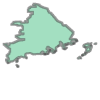

In [104]:
gid = 214
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [105]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [106]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

214: MultiPolygon has Inner Rings


## 5. Queries

### 5.1 Meta queries


Source: https://doc.rasdaman.org/04_ql-guide.html?highlight=rasql#sec-spatial-domain

In [252]:
q0 = 'select sdom(datacube) from Baveria_Temperature_MODIS_1km as datacube'

q_ansi = 'select sdom(datacube)[0] from Baveria_Temperature_MODIS_1km as datacube'    # 0:303

q_ansi_lower = 'select sdom(datacube)[0].lo from Baveria_Temperature_MODIS_1km as datacube'  # 0

q_ansi_upper = 'select sdom(datacube)[0].hi from Baveria_Temperature_MODIS_1km as datacube'  # 303

################################################################################################################

q_lat = 'select sdom(datacube)[1] from Baveria_Temperature_MODIS_1km as datacube'   # grid order 1 = Lat

q_lat_lower = 'select sdom(datacube)[1].lo from Baveria_Temperature_MODIS_1km as datacube' 

q_lat_upper = 'select sdom(datacube)[1].hi from Baveria_Temperature_MODIS_1km as datacube' 

################################################################################################################

q_long = 'select sdom(datacube)[2] from Baveria_Temperature_MODIS_1km as datacube'  # grid order 2 = Long

q_long_lower = 'select sdom(datacube)[2].lo from Baveria_Temperature_MODIS_1km as datacube' 

q_long_upper = 'select sdom(datacube)[2].hi from Baveria_Temperature_MODIS_1km as datacube' 

In [253]:
query2result(q0)

[0:303,0:395,0:583]


In [254]:
query2result(q_ansi), query2result(q_ansi_lower), query2result(q_ansi_upper)

0:303
0
303


(<rasdapy.models.result_array.ResultArray at 0x7f4f4071e250>,
 <rasdapy.models.result_array.ResultArray at 0x7f4f0c04fe20>)

In [255]:
gridtime = int("{}".format(query2result(q_ansi_upper)))+1;
gridLat = int("{}".format(query2result(q_lat_upper)))+1;
gridLong = int("{}".format(query2result(q_long_upper)))+1;

303
395
583


In [256]:
gridtime, gridLat, gridLong

(304, 396, 584)

### 5.2 Simple Queries

In [245]:
q1 = "select datacube[247, 0:* , 0:*] from Baveria_Temperature_MODIS_1km as datacube"

q2 = "select datacube[247, 0:* , 0:*]*0.02 from Baveria_Temperature_MODIS_1km as datacube" 

q3 = "select (datacube[247, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as datacube" 

q4 = "select (datacube[100, 0:* , 0:*]*0.02) > 200 from Baveria_Temperature_MODIS_1km as datacube"

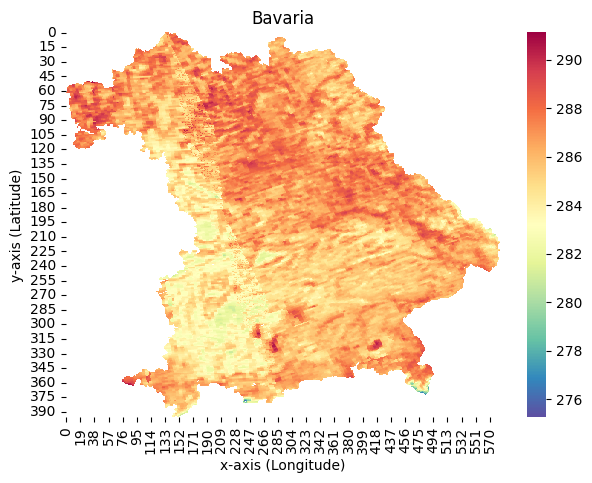

True

In [246]:
query2array2visuallize(q2, "Bavaria", 0)

In [247]:
query2array(q4) #boolean 

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

### 5.3 Aggregated Queries

* source: https://doc.rasdaman.org/04_ql-guide.html?highlight=rasql#condensers

In [243]:
q_avg = "select avg_cells((datacube[100:200, 0:* , 0:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km AS datacube" # for 101 rasters for 101 days

q_max = "select max_cells((datacube[100:200, 0:* , 0:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km AS datacube"

q_min = "select min_cells((datacube[100:200, 0:* , 0:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km AS datacube"

# -------------------------------------------------------------------------------------------------------------

q1_avg = "select avg_cells((datacube*0.02)-273.15) from Baveria_Temperature_MODIS_1km AS datacube"

q2_avg = "select avg_cells((datacube[0:*, 0:* , 0:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km AS datacube"

q9999 = "select datacube from Baveria_Temperature_MODIS_1km as datacube where all_cells((datacube[247, 0:* , 0:*]*0.02) > 200)"

In [240]:
query2numeric(q1_avg)

8.844479109103176

In [241]:
query2numeric(q2_avg)

8.844479109103176

In [244]:
query2result(q9999)

[]


### 5.x Condenser Queires

In [231]:
qCONDENSE_0 = 'select condense + over x in [200:201] using datacube[*:*, *:*, x[0]] from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_01 = 'select condense + over x in [200:201] using 0.02 * a[x[0],*:*, *:*] - 273.15 from Baveria_Temperature_MODIS_1km as a'

qCONDENSE_02 = 'select condense + over x in [200:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_03 = 'select condense + over x in [199:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_05 = 'select condense min over x in [199:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_06 = 'select condense max over x in [199:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_07 = 'select condense + over x in [199:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15)/3 from Baveria_Temperature_MODIS_1km as datacube'

####### EXP ######################################################################################################################################

qCONDENSE_07x = 'select condense + over x in [199:201] using avg_cells((datacube[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_07xx = 'select condense + over x in [199:201] using ((datacube[x[0],*:*, *:*]*0.02) - 273.15)/len(x) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_07xxx = 'select x in [200:201] using sum_cells(datacube[x[0],*:*, *:*]) / card(datacube[x[0],*:*, *:*]) from Baveria_Temperature_MODIS_1km as datacube'

qCONDENSE_07xxxx = 'select condense + over x in [199:201] using datacube[x[0],*:*, *:*] / card(sdom(datacube)) from Baveria_Temperature_MODIS_1km as datacube'

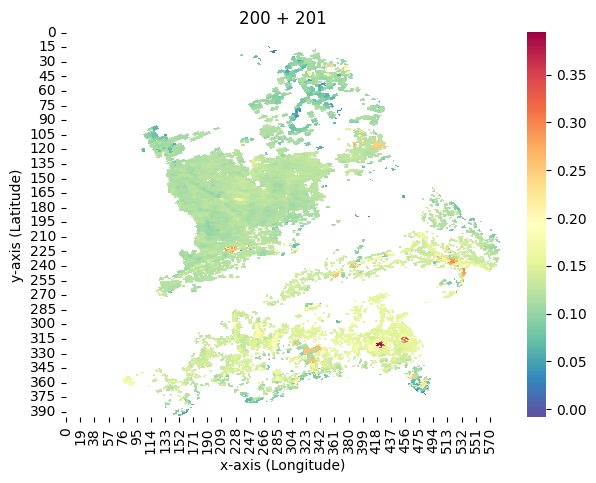

True

In [169]:
query2array2visuallize(qCONDENSE_01,"200 + 201", 0)

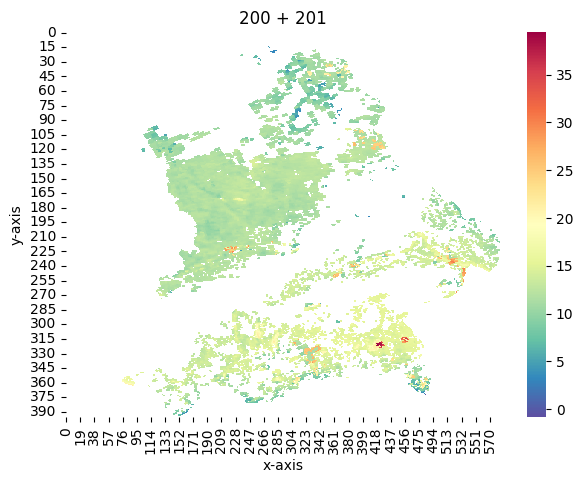

True

In [291]:
query2array2visuallize(qCONDENSE_02,"200 + 201", 0)

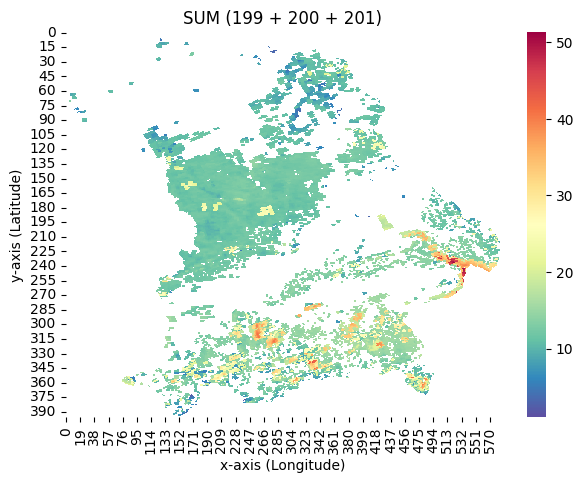

True

In [179]:
query2array2visuallize(qCONDENSE_03, "SUM (199 + 200 + 201)", 0)

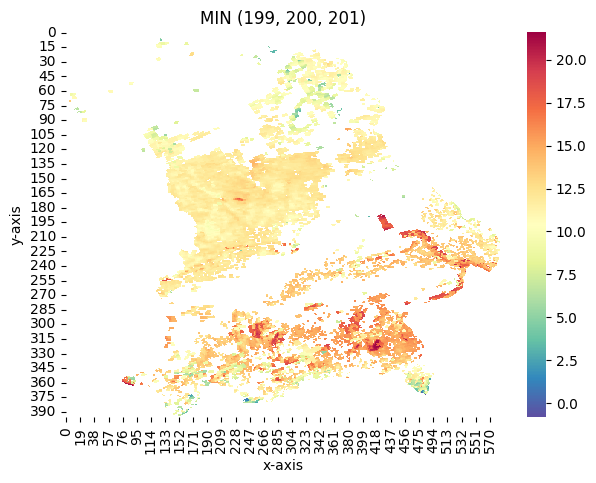

True

In [298]:
query2array2visuallize(qCONDENSE_05, "MIN (199, 200, 201)", 0)

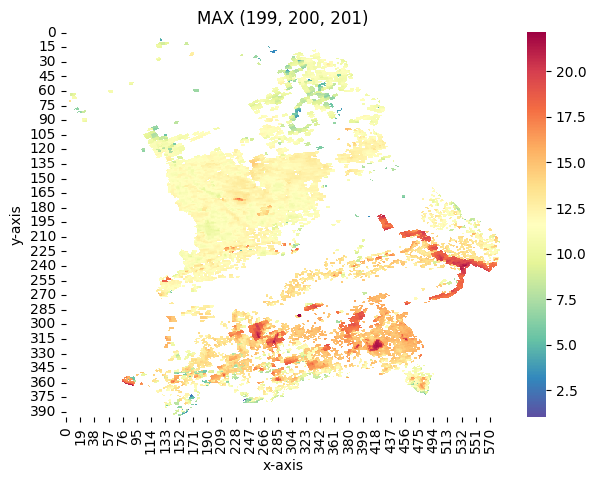

True

In [299]:
query2array2visuallize(qCONDENSE_06, "MAX (199, 200, 201)", 0)

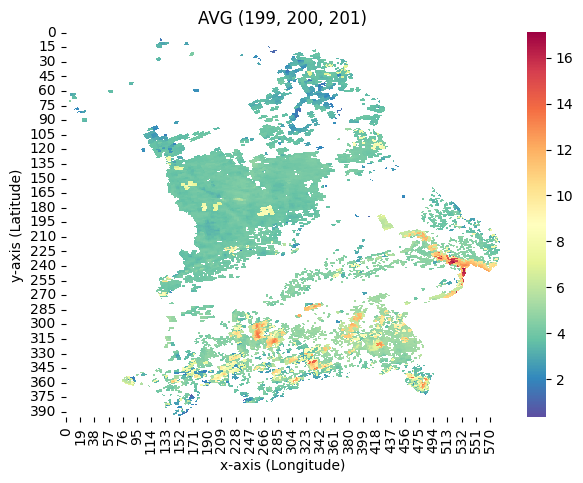

True

In [176]:
query2array2visuallize(qCONDENSE_07, "AVG (199, 200, 201)", 0) ## Manual

In [232]:
query2array2visuallize(qCONDENSE_07x, "AVG (199, 200, 201)", 0) ## using length(x)

AttributeError: 'NoneType' object has no attribute 'intervals'

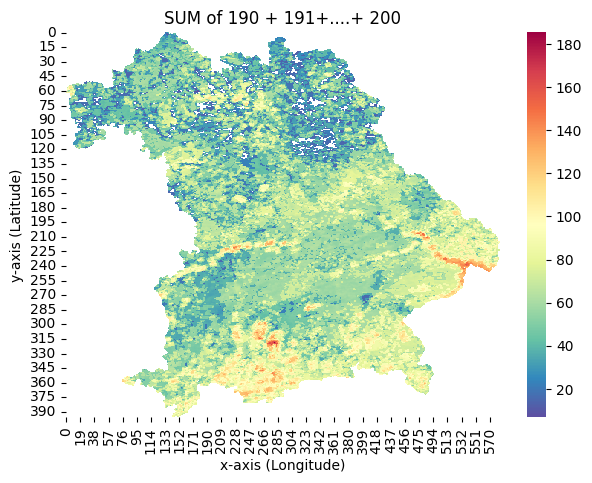

True

In [223]:
qCONDENSE_04a = 'select condense + over x in [190:200] using ((mr[x[0],*:*, *:*]*0.02) - 273.15) from Baveria_Temperature_MODIS_1km as mr'

query2array2visuallize(qCONDENSE_04a, "SUM of 190 + 191+....+ 200", 0)

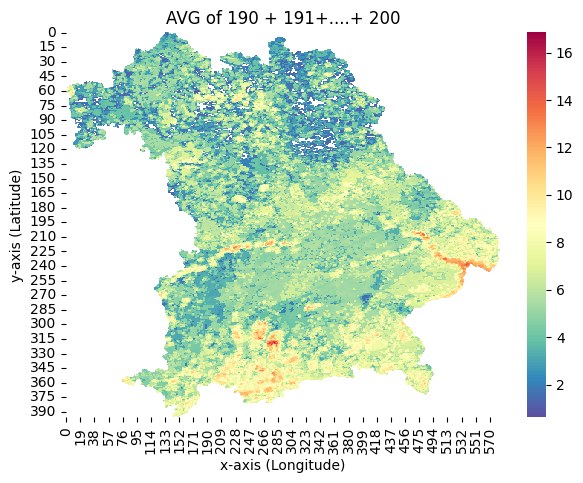

True

In [224]:
qCONDENSE_04a = 'select condense + over x in [190:200] using ((mr[x[0],*:*, *:*]*0.02) - 273.15)/11 from Baveria_Temperature_MODIS_1km as mr'

query2array2visuallize(qCONDENSE_04a, "AVG of 190 + 191+....+ 200", 0)

### 5.2 Spatial Queries

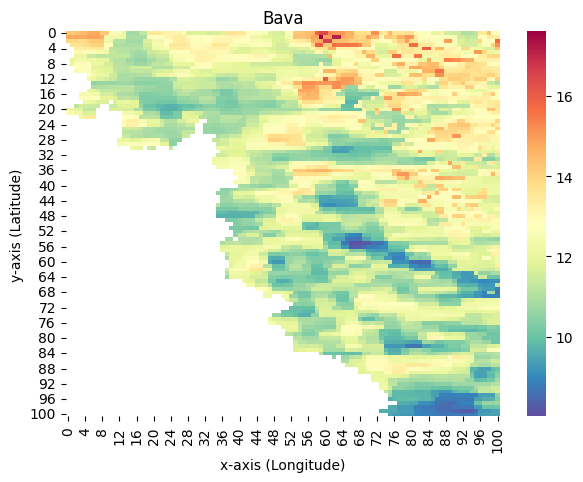

True

In [263]:
qSPACE = "select (m[247, 100:200 , 100:200]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m"
query2array2visuallize(qSPACE, "Bava", 0)

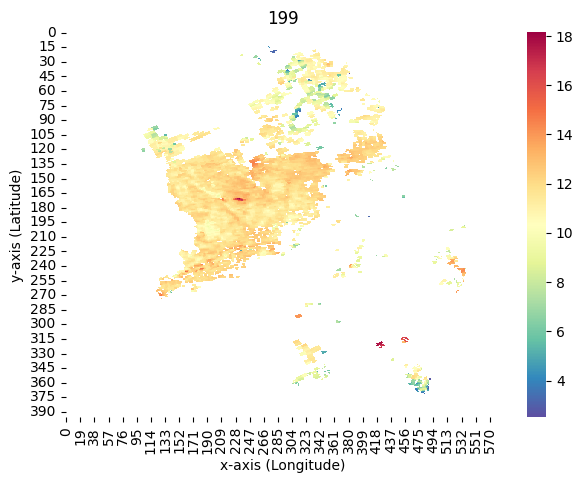

True

In [264]:
qSPACE01 = "select (m[199, 0:*, 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m"
query2array2visuallize(qSPACE02, "199", 0)

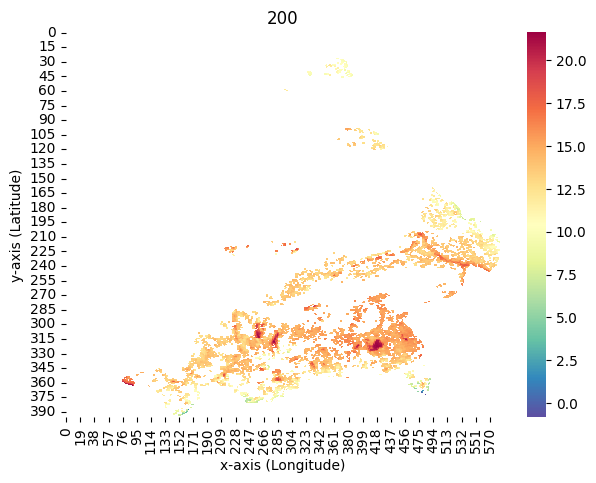

True

In [265]:
qSPACE02 = "select (m[200, 0:*, 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m"
query2array2visuallize(qSPACE02, "200", 0)

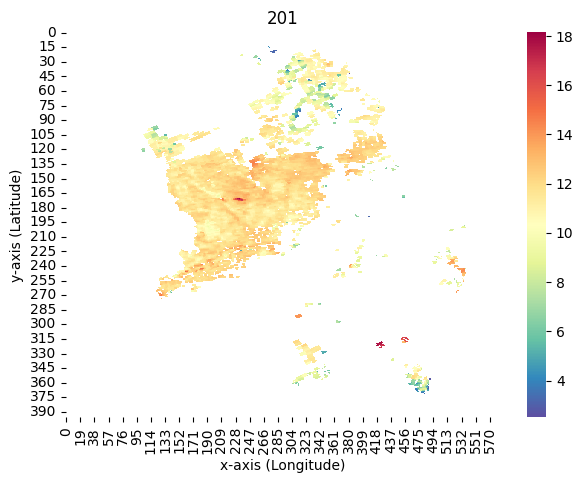

True

In [266]:
qSPACE02 = "select (m[201, 0:*, 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as m"
query2array2visuallize(qSPACE02, "201", 0)

### 5.3 Temporal Queries

In [257]:
qTIME01 = "select avg_cell(datacube[247:252, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as datacube" 

qTIME02 = "select avg_cell(datacube[229:232, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as datacube" 

qTIME03 = "select avg_cells(clip((datacube[18:20, 0:* , 0:*]*0.02)- 273.15, POLYGON ((467 681, 467 764, 720 764, 615 662, 467 681)))) from Surface_Temperature_Sweden AS datacube" 

In [258]:
query2numeric(qTIME01)

15.247390265896001

In [259]:
query2numeric(qTIME02)

19.55567204933584

In [261]:
query2numeric(qTIME03) # ISSUE 

Exception: Error executing query 'select avg_cells(clip((datacube[18:20, 0:* , 0:*]*0.02)- 273.15, POLYGON ((467 681, 467 764, 720 764, 615 662, 467 681)))) from Surface_Temperature_Sweden AS datacube', error message 'rasdaman error 507: Exception: The dimension of the points differs from that of the MDD object in which they are expected to lie.'

### 5.4 Spatial-Temporal Queries

In [267]:
qSP= "select avg_cell(datacube[246:252, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as datacube" 
query2numeric(qSP)

15.047650633861508

## 4. Source Preparaiton